In [1]:
"""
dataset yang digunakan diperoleh dari https://www.kaggle.com/roopahegde/cryptocurrency-timeseries-2020. dataset ini merupakan dataset harga currency bitcoin dalam USD.
memiliki 658065 baris, merupakan data timeseries dari 1 januari 2020 hingga 20 april 2021. untuk analisis ini hanya 15 ribu baris terakhir.
memiliki 24 kolom, namun kolom yang digunakan unfuk analisis forecasting hanya kolom 'Date' dan 'open'. date mendeskripsikan hari hingga menit terakhir,
open menampilkan harga bitcoin saat dibuka di menit tertentu.
alur analisis yaitu mengkonversi date menjadi unix timestamp sebagai ID, kemudian dataset diambil 15000 baris terakhir, windowing, membangun model, lalu training dan evaluasi.

"""

"\ndataset yang digunakan diperoleh dari https://www.kaggle.com/roopahegde/cryptocurrency-timeseries-2020. dataset ini merupakan dataset harga currency bitcoin dalam USD.\nmemiliki 658065 baris, merupakan data timeseries dari 1 januari 2020 hingga 20 april 2021. untuk analisis ini hanya 15 ribu baris terakhir.\nmemiliki 24 kolom, namun kolom yang digunakan unfuk analisis forecasting hanya kolom 'Date' dan 'open'. date mendeskripsikan hari hingga menit terakhir,\nopen menampilkan harga bitcoin saat dibuka di menit tertentu.\nalur analisis yaitu mengkonversi date menjadi unix timestamp sebagai ID, kemudian dataset diambil 15000 baris terakhir, windowing, membangun model, lalu training dan evaluasi.\n\n"

In [2]:
import pandas as pd 

# ekstrak file terlebih dahulu
df = pd.read_csv('./dataset/gemini_BTCUSD_2020_1min.csv')
df.head()
# data baris pertama merupakan data tanggal dan menit terakhir, sedangkan model membaca data untuk training dari atas ke bawah.
# kita ingin pada setiap iterasi training, model memprediksi data masa depan, sehingga kita perlu membalik data awal 
df = df.iloc[::-1]
df.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
658064,1.577840e+12,1/1/2020 0:00,BTCUSD,7165.9,7170.79,7163.3,7163.3,0.007931
658063,1.577840e+12,1/1/2020 0:01,BTCUSD,7163.3,7164.23,7163.3,7163.3,0.002646
658062,1.577840e+12,1/1/2020 0:02,BTCUSD,7163.3,7164.22,7163.0,7163.0,0.063904
658061,1.577840e+12,1/1/2020 0:03,BTCUSD,7163.0,7163.60,7163.0,7163.6,0.002706
658060,1.577840e+12,1/1/2020 0:04,BTCUSD,7163.6,7163.60,7163.0,7163.0,1.751844


In [3]:
import math
n = 15000
n_train = int(math.floor(0.2*n))
n_test = n-n_train
print('banyak data : ', len(df))
print('banyak data yang digunakan : ',n)
print('banyak data training : ', n_train)
print('banyak data testing : ', n_test)
print('banyak data yang null :')
df.isnull().sum()

banyak data :  658065
banyak data yang digunakan :  15000
banyak data training :  3000
banyak data testing :  12000
banyak data yang null :


Unix Timestamp    0
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64

In [4]:
import time
import datetime

# konversi tanggal ke unix timestamp
tanggal = df['Date']
tanggal
tanggal_unix = tanggal.map(lambda x : time.mktime(datetime.datetime.strptime(x, "%m/%d/%Y %H:%M").timetuple()))

In [5]:
# masukan tanggal_unix ke df
tanggal_unix_str = tanggal_unix.map(lambda x : str(x))
tanggal_unix_str.name = 'Date_Unix'
ds = pd.concat([df, tanggal_unix_str], axis=1)
ds.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume,Date_Unix
658064,1.577840e+12,1/1/2020 0:00,BTCUSD,7165.9,7170.79,7163.3,7163.3,0.007931,1577811600.0
658063,1.577840e+12,1/1/2020 0:01,BTCUSD,7163.3,7164.23,7163.3,7163.3,0.002646,1577811660.0
658062,1.577840e+12,1/1/2020 0:02,BTCUSD,7163.3,7164.22,7163.0,7163.0,0.063904,1577811720.0
658061,1.577840e+12,1/1/2020 0:03,BTCUSD,7163.0,7163.60,7163.0,7163.6,0.002706,1577811780.0
658060,1.577840e+12,1/1/2020 0:04,BTCUSD,7163.6,7163.60,7163.0,7163.0,1.751844,1577811840.0


In [6]:
date = ds[['Date_Unix','Date']]
x = ds['Open']

# mengambil 15000 data terakhir
total_date = date.iloc[-n:]
total_x = x.iloc[-n:]

#split data training dan testing
date_train, date_test = total_date.iloc[:-n_train], total_date.iloc[-n_train:]
x_train, x_test = total_x.iloc[:-n_train], total_x.iloc[-n_train:]

train_data = pd.concat([date_train, x_train], axis = 1)
test_data = pd.concat([date_test, x_test], axis = 1)
x_train, x_test = x_train.values, x_test.values

In [87]:
print('banyak data training : ', len(x_train))
print('banyak data testing : ', len(x_test))
print('total data : ', len(x_train)+len(x_test))

x_max = max(total_x)
x_min = min(total_x)
print('nilai maksimum x dan y : ',x_max)
print('nilai minimum x dan y : ', x_min)

banyak data training :  12000
banyak data testing :  3000
total data :  15000
nilai maksimum x dan y :  64890.0
nilai minimum x dan y :  52072.71


In [88]:
# standardizing x dengan min max scaler

def scaler(data, x_max, x_min):
    return [ ((x-x_min)/(x_max-x_min)) for x in data]

scaled_x_train = scaler(x_train, x_max, x_min)
scaled_x_test = scaler(x_test, x_max, x_min)

In [89]:
# plot data train dan test
import plotly.graph_objects as go

fig = go.Figure()
# plot data training
fig.add_trace(go.Scatter(x=train_data['Date_Unix'], y=train_data['Open'],mode='lines',
                    name='training'))
# plot data testing
fig.add_trace(go.Scatter(x=test_data['Date_Unix'], y=test_data['Open'],mode='lines',
                    name='testing'))
fig.show()

In [99]:
# fungsi untuk membuat data testing bisa diolah oleh model
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    # print("hasil tf.expand_dims",series)

    ds = tf.data.Dataset.from_tensor_slices(series)
    # print("hasil tf.data.Dataset.from_tensor_slices", ds.__str__())
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # print("hasil ds.window ",ds)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # print("hasil ds.flat_map ",ds)
    ds = ds.shuffle(shuffle_buffer)
    # print("hasil ds.shuffle ",ds)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    # print("hasil ds.map ", ds)
    return ds.batch(batch_size).prefetch(1) 

In [100]:
train_set = windowed_dataset(scaled_x_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(scaled_x_test, window_size=60, batch_size=100, shuffle_buffer=1000)


In [101]:
# arsitektur modle
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1),
])

In [104]:
# callback dan optimizer

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

# update learning rate, berfokus pada metrik validation mae, mengubah learning rate menjadi 0.75 lr awal
# melakukan update apabila setelah 2 epoch, validation mae tidak menghasilkan selisih 500 dari validation mae 2 epoch sebelumnya
updateLRonPlateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_mae',
    factor = 0.5,
    patience=2,
    min_delta = 0.1,
)

# scheduler mengupdate lr menjadi 0.1 learning rate awal apabila epoch sudah lebih dari 40
def scheduler(epoch, lr):
    if epoch < 51:
        return lr
    else:
        return lr * 0.5

lRScheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# callback early stopping, digunakan saat metrik yang diamati sudah dirasa konvergen
earlyStopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="mae",
    min_delta=0.1,
    patience=5,
    verbose=0,
    mode="min",
)
callbacks = [updateLRonPlateau_callback, lRScheduler_callback, earlyStopping_callback]

In [105]:
model.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer,
metrics=['mae'])

history = model.fit(train_set, validation_data=test_set, epochs=100 , callbacks = callbacks)

Epoch 1/100
120/120 [==============================] - 18s 100ms/step - loss: 0.0065 - mae: 0.0826 - val_loss: 0.0379 - val_mae: 0.2661
Epoch 2/100
120/120 [==============================] - 11s 94ms/step - loss: 0.0027 - mae: 0.0548 - val_loss: 0.0086 - val_mae: 0.1166
Epoch 3/100
120/120 [==============================] - 12s 98ms/step - loss: 5.9134e-05 - mae: 0.0080 - val_loss: 0.0065 - val_mae: 0.0988
Epoch 4/100
120/120 [==============================] - 12s 96ms/step - loss: 5.2651e-05 - mae: 0.0073 - val_loss: 0.0062 - val_mae: 0.0968
Epoch 5/100
120/120 [==============================] - 11s 94ms/step - loss: 4.6084e-05 - mae: 0.0067 - val_loss: 0.0060 - val_mae: 0.0938
Epoch 6/100
120/120 [==============================] - 12s 95ms/step - loss: 4.6374e-05 - mae: 0.0067 - val_loss: 0.0059 - val_mae: 0.0934


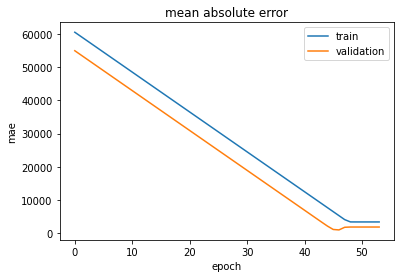

In [46]:
# plot MAE
import matplotlib.pyplot as plt 
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('mean absolute error')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()